# 1 Import and preprocessing of the xml data files

In this script we implement the importing technique of xml files in python and their preprocessing before feeding them on the fly to gensim in order to create the embeddings. 

### Naming Convention

* Source: when I write source I mean the name of a newspaper such as: (il gazzettino, ilcorriere etc.). The list of newspapers and their number of articles in the period can be found in the catalogue <p1/(p2)_source_count.txt>.


###  Requirements

Before launching the script, it is necessary to have the classification of the various sources in a file of the type <p1_p2_common_source_party.txt> in which the political part of the newspaper or its regionality is classified. If you want to work with both periods, you should refer to the file <p1_p2_common_newspapers_titles_list.txt>.

### More informations 

 * Number of articles: 331k 2017-2018 and 591k for 2022
 * Time periods: from december 2017 to april 2018 and from june 2022 to october 2022

## 1.1 Creation of the txt file with the news

The first step consists in the creation of many text file where the content of the newspapers is saved. The content of this newspaper is saved in xml files, so this part of preprocessing is required.

The parameters required for this step are:

* (DATA_DIRECTORY -> string) As first thing we have to define the global directory where all the data like <p1_1.xml>, <p2_2.xml>... are found

* (PATH_TO_SOURCE_PARTY_TXT -> string) We then define the name of the of the file containing our classification

* (PERIOD -> string) This global variable defines the period we want to analyze. It can be <p1> or <p2>

* (N_FILES -> int) This variable declare the number of files of the period the we previously defined that we want to analyze and so to save into our txt file. For the first period there are 1659 files and 2959 for the second.

* (POLITICAL SIDE -> string) The political side can be '0' if we want the **left** party news, '1' for the **center** party news, '2' for the **right** or 'un' if we want **unclassified** newspapers. Alternatively we can specify 'nord', 'sud', or 'un' providing the regionality text catalog.

The output text filename will sum up all these choices.

In [16]:
DATA_DIRECTORY = 'D:\Data Science UNIPD\Cluster_tesi\pietromaria.sanguin-data'
PATH_TO_SOURCE_PARTY_TXT = 'p1_p2_common_source_party.txt'
PERIOD = 'p2'
N_FILES = 2959
POLITICAL_SIDE = '2'

TEXT_FILENAME = f'{PERIOD}_{POLITICAL_SIDE}side_{N_FILES}files.txt'

In [17]:
#Function to import a txt file as a dictionary
def import_txt_as_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            data_dict[key.strip()] = value.strip()
    return data_dict


We now define the way in which the xml is processed. This script is studied to work with this specific xml syntax. 

In [18]:
# Functions to create the txt file with the text of the articles of a specific political side and a specific period

import xml.etree.ElementTree as ET

def accessing_single_xml_text(file_path, source_classification_dict, political_side, output_file):
    '''* file_path is a path to a specific xml file (it will be defined iteratively later)
       * source classification dict is the python dictionary containing the mapping of newspapers to political side
       * political_side is a string containing '1', '2', 0 
       * output_file is the path to the text file where output will be saved'''
    
    # Namespace mapping
    namespace_map = {
        'emm': 'http://emm.jrc.it'
    }

    # Parse the XML file with namespace mapping
    tree = ET.ElementTree()
    tree.parse(file_path)
    root = tree.getroot()
    channel = root.find('channel')

    # To access item elements (articles) and their attributes:
    for item in channel.findall('item'):
        item_source = item.find('source').text
        if source_classification_dict.get(str(item_source)) == political_side:     
            item_text_element = item.find('emm:text', namespaces=namespace_map)
            if item_text_element is None:
                continue  # Skip this iteration and continue to the next item
        
            item_text = item_text_element.text
            if item_text is not None:
                with open(output_file, 'a', encoding='utf-8') as f:
                    f.write(item_text + '\n')

In [19]:
def accessing_multiple_xml_text(n_files, period, source_classification_dict, political_side, output_file):
    '''* n_files is the number of files that I want to read
        * period is a string p1 or p2
        * source_classification_dict is the dictionary with the political classification
        * Political_side is a string containing '1', '2', 0 
        * output_file is the path to the text file where output will be saved'''
    
    for i in range(1, n_files+1):
        file_path = f'{DATA_DIRECTORY}\{period}_{i}.xml'
        accessing_single_xml_text(file_path, source_classification_dict, political_side, output_file)

The next void function create the required txt file. It could take some time if the N_FILES is large

In [20]:
source_classification_dict = import_txt_as_dict(PATH_TO_SOURCE_PARTY_TXT)
accessing_multiple_xml_text(N_FILES, PERIOD, source_classification_dict, POLITICAL_SIDE, TEXT_FILENAME)

# 2 PREPROCESSING OF THE TEXT

Now that we have a txt file with all the text we desire we can start the preprocessing part.
Inside our txt we have just the content of the article so we are not considering the title.
For what concern the text preprocessing we apply the following


* Remove all the non-alphanumeric tokens
* We lower case everything
* Remove direct quotes (frasi tra virgolette)
* Non ASCII characters replaced by thei closest ASCII equivalent 
* Periods removed excepet when not indicatin a end of sentence
* Numerals removed except they are ordinals first, second...



An other hypothesis could be removing all the proper names (words starting with a capital letter), however we decided to not apply this. The sma thing apply to the following preprocessing idea: End of sentence periods replaced with PERIOD

In [21]:
OUTPUT_FILENAME = TEXT_FILENAME.replace(".txt", "") + "_preprocessed.txt"

In [22]:
import re
from unidecode import unidecode

def preprocessing(input_filename, output_filename):
    # Load the text
    with open(input_filename, "r", encoding="utf-8") as file:
        text = file.read()

    # Removing text inside quotation marks
    #text = re.sub(r'"[^"]+"', '', text)

    # Sobstitution of non-ASCII characters
    text = unidecode(text)

    #Removing punctuation exept from dots, spaces and apostrophes
    #text = re.sub(r'[^\w\s.\']', lambda match: ' ' if match.group() == "'" else '', text)

    #Removing punctuation exept from spaces and apostrophes
    text = re.sub(r'[^\w\s\']', '', text)

    #Sobstitution of apostrophes with spaces
    text = re.sub(r"\'", " ", text)

    #All the text to lowercase
    text = text.lower()

    #Remove </s>
    text = text.replace("</s>", "")

    # Removing dots with PERIOD
    #text = text.replace(".", " PERIOD ")
    

    # Removal of integers inside and outside words, replacement of ordinals
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.replace("1o", "primo")
    # Aggiungi altre sostituzioni di numeri ordinali se necessario

    # Sobstituting multiple spaces and newlines with a single newline
    text = re.sub(r"(\n\s*)+", "\n", text)
    
    # Saving the preprocessed text
    with open(output_filename, "w", encoding="utf-8") as file:
        file.write(text)




The following line preprocess the text.

In [23]:
preprocessing(TEXT_FILENAME, OUTPUT_FILENAME)

In [24]:
sprint

NameError: name 'sprint' is not defined

# 3 EMBEDDINGS COMPUTATION

The script for the creation of embeddings starting from the preprocessed txt file can be found in the script **Embeddings_creation.ipynb**. Following that notebook you will be able to recreate the desired embeddings. There exist a way to generate embeddings on the fly in a more efficient way as reported in the next section. However in this methodology we did not completly implemented a full preprocessing.

In [ ]:
#Function to import a txt file as a dictionary
def import_txt_as_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            data_dict[key.strip()] = value.strip()
    return data_dict

file_path = 'p1_p2_common_source_party.txt'
source_classification_dict = import_txt_as_dict(file_path)

In [ ]:
# Functions to create the txt file with the text of the articles of a specific political side and a specific period

import xml.etree.ElementTree as ET

def accessing_single_xml_text(file_path, source_classification_dict, political_side, output_file):
    '''* file_path is a path to a specific xml file
       * source classification dict is the python dictionary containing the mapping of newspapers to political side
       * political_side is a string containing '1', '2', 0 
       * output_file is the path to the text file where output will be saved'''
    
    # Namespace mapping
    namespace_map = {
        'emm': 'http://emm.jrc.it'
    }

    # Parse the XML file with namespace mapping
    tree = ET.ElementTree()
    tree.parse(file_path)
    root = tree.getroot()
    channel = root.find('channel')

    # # To access item elements (articles) and their attributes:
    # for item in channel.findall('item'):
    #     item_source = item.find('source').text
    #     if source_classification_dict.get(str(item_source)) == political_side:     
    #         item_text = item.find('emm:text', namespaces=namespace_map).text
    #         with open(output_file, 'a', encoding='utf-8') as f:
    #             f.write(item_text + '\n')

    # To access item elements (articles) and their attributes:
    for item in channel.findall('item'):
        item_source = item.find('source').text
        if source_classification_dict.get(str(item_source)) == political_side:     
            item_text_element = item.find('emm:text', namespaces=namespace_map)
            if item_text_element is None:
                continue  # Skip this iteration and continue to the next item
        
            item_text = item_text_element.text
            if item_text is not None:
                with open(output_file, 'a', encoding='utf-8') as f:
                    f.write(item_text + '\n')

def accessing_multiple_xml_text(n_files, period, source_classification_dict, political_side, output_file):
    '''* n_files is the number of files that I want to read
        * period is a string p1 or p2
        * source_classification_dict is the dictionary with the political classification
        * Political_side is a string containing '1', '2', 0 
        * output_file is the path to the text file where output will be saved'''
    
    for i in range(1, n_files+1):
        file_path = f'D:\\Data Science UNIPD\\Cluster_tesi\\pietromaria.sanguin-data\\{period}_{i}.xml'
        accessing_single_xml_text(file_path, source_classification_dict, political_side, output_file)





In [ ]:
n_files = 8
period = 'p1'
political_side = '0'
text_file_name = 'p1_0_flies8.txt'

accessing_multiple_xml_text(n_files, period, source_classification_dict, political_side, text_file_name)

## Preprocessing of the file containing the text

In [ ]:
import re
from unidecode import unidecode

def preprocessing(input_filename, output_filename):
    # Load the text
    with open(input_filename, "r", encoding="utf-8") as file:
        text = file.read()

    # Removing text inside quotation marks
    #text = re.sub(r'"[^"]+"', '', text)

    # Sobstitution of non-ASCII characters
    text = unidecode(text)

    #Removing punctuation exept from dots, spaces and apostrophes
    #text = re.sub(r'[^\w\s.\']', lambda match: ' ' if match.group() == "'" else '', text)

    #Removing punctuation exept from spaces and apostrophes
    text = re.sub(r'[^\w\s\']', '', text)

    #Sobstitution of apostrophes with spaces
    text = re.sub(r"\'", " ", text)

    #All the text to lowercase
    text = text.lower()

    #Remove </s>
    text = text.replace("</s>", "")

    # Removing dots with PERIOD
    #text = text.replace(".", " PERIOD ")
    

    # Rimozione dei numeri interi, sostituzione degli ordinals
    text = re.sub(r'\b\d+\b', '', text)
    text = text.replace("1o", "primo")
    # Aggiungi altre sostituzioni di numeri ordinali se necessario

    # Sobstituting multiple spaces and newlines with a single newline
    text = re.sub(r"(\n\s*)+", "\n", text)
    
    # Salva il testo preelaborato nel nuovo file
    with open(output_filename, "w", encoding="utf-8") as file:
        file.write(text)




In [ ]:
# Utilizzo della funzione per preelaborare il testo
output_filename = text_file_name.replace(".txt", "") + "_preprocessed.txt"
preprocessing(text_file_name, output_filename)

In [ ]:
sprint

NameError: name 'sprint' is not defined

In [ ]:
import gensim.models

#sentences = MyCorpus(n_files=1660, period='p1', political_side='1')
sentences = MyCorpus(n_files=1658, period='p1')
model = gensim.models.Word2Vec(sentences=sentences, vector_size=300, window = 5, seed=42, epochs= 5)

In [ ]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/154381 is di
word #1/154381 is il
word #2/154381 is la
word #3/154381 is che
word #4/154381 is in
word #5/154381 is per
word #6/154381 is del
word #7/154381 is un
word #8/154381 is della
word #9/154381 is non


### Saving the model

Note: before saving the model is important to change the *prefix* parameter in order to save the model into another file.

In [ ]:
import os
import gensim.models
import tempfile

# Specify the folder where you want to create the temporary file
tmp_dir = "D:\\Data Science UNIPD\\Cluster_tesi\\tmp"

# Ensure the temporary directory exists, create if not
os.makedirs(tmp_dir, exist_ok=True)

# Create a temporary file with a specific prefix in the specified directory
with tempfile.NamedTemporaryFile(prefix='gensim-model-p1-all', dir=tmp_dir, delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)

    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.



In [ ]:
#
# To load a saved model:
#
new_model = gensim.models.Word2Vec.load('D:\\Data Science UNIPD\\Cluster_tesi\\tmp\\gensim-model-p1-0left9zwnrv23')

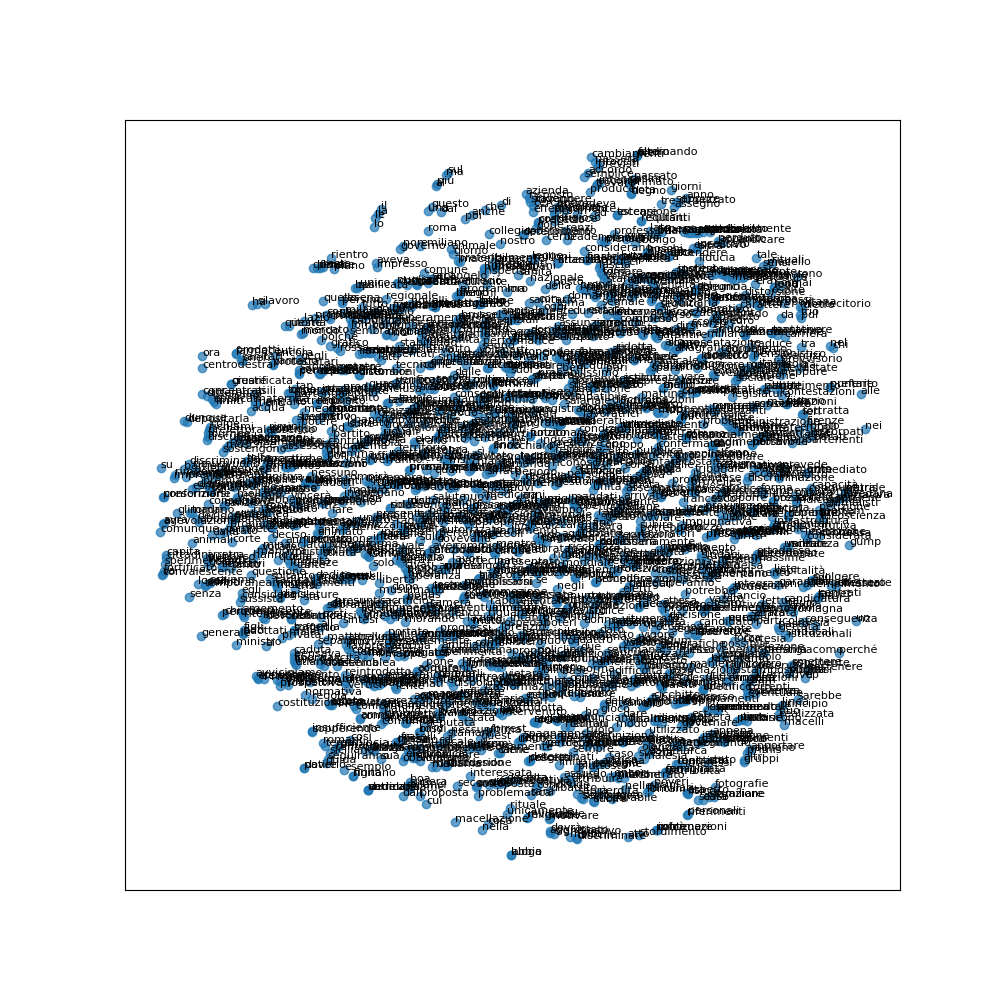

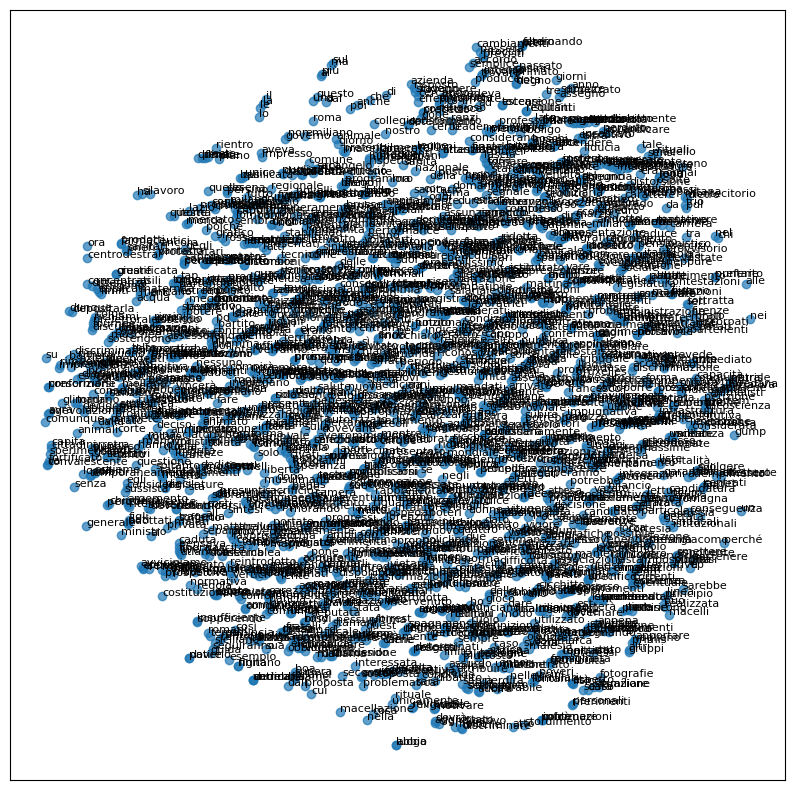

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import Image


# Load the pre-trained Word2Vec model
model = Word2Vec.load('D:\\Data Science UNIPD\\Cluster_tesi\\tmp\\gensim-model-p1-0left9zwnrv23')  # Replace 'path_to_model' with the actual path to your trained model

# Get the vocabulary and word vectors from the model
vocab = model.wv.index_to_key
word_vectors = model.wv[vocab]

# Perform dimensionality reduction using t-SNE, I use cosine metric
tsne = TSNE(n_components=2, perplexity=50, metric = 'cosine')
tsne_result = tsne.fit_transform(word_vectors)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)

# Annotate the points with the corresponding words
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(tsne_result[i, 0], tsne_result[i, 1]), fontsize=8)

plt.xticks([])
plt.yticks([])
plt.savefig('tsne_plot.png')
Image('tsne_plot.png')

## Comparison of the newspapers of the first and the second period

The model will be trained on the intersection of the newspapers of the two periods. What is this intersection?

In [ ]:
#Function to import a txt file as a dictionary
def import_txt_as_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            data_dict[key.strip()] = value.strip()
    return data_dict

file_path_p1 = 'p1_source_count.txt'
source_count_dict_p1 = import_txt_as_dict(file_path_p1)

file_path_p2 = 'p2_source_count.txt'
source_count_dict_p2 = import_txt_as_dict(file_path_p2)

FileNotFoundError: [Errno 2] No such file or directory: 'p1_source_count.txt'

In [ ]:
# Trova le chiavi comuni
chiavi_comuni = source_count_dict_p1.keys() & source_count_dict_p2.keys()

# Salva le chiavi comuni in un file txt
with open("p1_p2_common_newspapers_titles_list.txt", "w") as file:
    for chiave in chiavi_comuni:
        file.write(chiave + "\n")

# Stampa le chiavi non comuni
chiavi_non_comuni_p1 = source_count_dict_p1.keys() - source_count_dict_p2.keys()
chiavi_non_comuni_p2 = source_count_dict_p2.keys() - source_count_dict_p1.keys()

print("Chiavi comuni:", chiavi_comuni, len(chiavi_comuni))
print("Chiavi non comuni nel primo dizionario:", chiavi_non_comuni_p1)
print("Chiavi non comuni nel secondo dizionario:", chiavi_non_comuni_p2)


Chiavi comuni: {'lasiciliaweb', 'ansa-Europa', 'euractiv-it', 'picenooggi', 'gazzettadireggio', 'ilfattoalimentare', 'lacittadisalerno', 'redattoresociale', 'ilpiccolo', 'ilrestodelcarlino', 'pugliapress', 'lavocedelnordest', 'ilcrotonese', 'gazzetta', 'pnquotidiano', 'pisatoday', 'analisidifesa', 'ilgiorno', 'milanofinanza', 'ilgiornaledisalerno', 'finanza-lastampa', 'prnewswire', 'firenzetoday', 'corrieredelveneto', 'fanoinforma', 'primapress', 'milanofree', 'parmadaily', 'radioluna', 'agenparl', 'verbanianotizie', 'ilsecoloxix', 'ottopagine', 'cdt', 'cilentonotizie', 'veronasera', 'gofasano', 'investireoggi', 'spoletonline', 'blogsicilia', 'latina24ore', 'reteambiente', 'gazzettadellaspezia', 'iltirreno', 'brevanews', 'tribunatreviso', 'tvsvizzera', 'zerosettenews', 'forlitoday', 'cronacaqui', 'avvenire', 'arezzoweb', 'anconatoday', 'baritoday', 'vivienna', 'uscatanzaro', 'cagliaripad', 'ecodisicilia', 'metronews', 'espressorepubblica-MicroMega', 'ilcentro', 'aboutpharma', 't-mag', 

In [ ]:
# Trova le chiavi comuni
chiavi_comuni = source_count_dict_p1.keys() & source_count_dict_p2.keys()


# Calcola la somma dei valori comuni per il primo dizionario
somma_valori_p1 = sum(int(source_count_dict_p1[key]) for key in chiavi_comuni)

# Calcola la somma dei valori comuni per il secondo dizionario
somma_valori_p2 = sum(int(source_count_dict_p2[key]) for key in chiavi_comuni)

print("Somma valori comuni per il primo dizionario:", somma_valori_p1)
print("Somma valori comuni per il secondo dizionario:", somma_valori_p2)

Somma valori comuni per il primo dizionario: 260008
Somma valori comuni per il secondo dizionario: 342804


Cioè nel secondo periodo i giornali hanno pubblicato (almeno le testate comuni un po' di più). Comunque forse il periodo è un po' più lungo

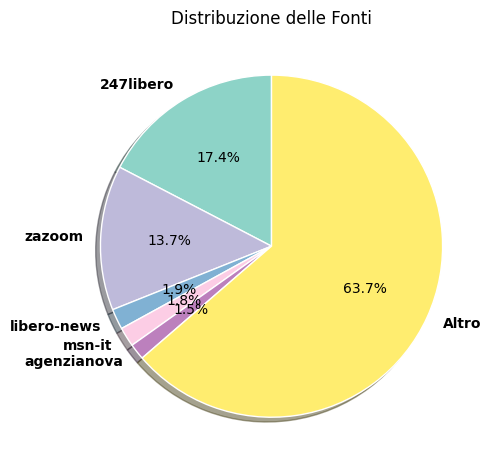

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che tu abbia un dizionario source_count_dict_p1 con i dati delle fonti e dei conteggi

# Estrai i titoli e i conteggi dal dizionario
labels = np.array(list(source_count_dict_p1.keys()))
sizes = np.array(list(source_count_dict_p1.values()), dtype=float)  # Converte i valori in float

# Trova gli indici dei 5 titoli con il maggior numero di articoli
top_five = sizes.argsort()[-5:][::-1]

# Calcola il totale dei conteggi delle fonti tranne le prime 5
other_size = np.sum(sizes) - np.sum(sizes[top_five])

# Aggiungi la categoria "Altro" alla lista di etichette e alle dimensioni
labels1 = np.append(labels[top_five], 'Altro')
sizes1 = np.append(sizes[top_five], other_size)

# Evidenzia i 5 titoli principali con colori diversi
colors = plt.cm.Set3(np.linspace(0, 1, len(labels1)))

# Crea il grafico a torta
fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes1, labels=labels1, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

# Aggiungi bordi alle fette
for wedge in wedges:
    wedge.set_edgecolor('white')

# Aggiungi label alle fette con percentuali
for text in texts:
    text.set_fontsize(10)
    text.set_fontweight('bold')

# Aggiungi titolo al grafico
ax1.set_title("Distribuzione delle Fonti")

# Mostra il grafico
plt.tight_layout()
plt.show()


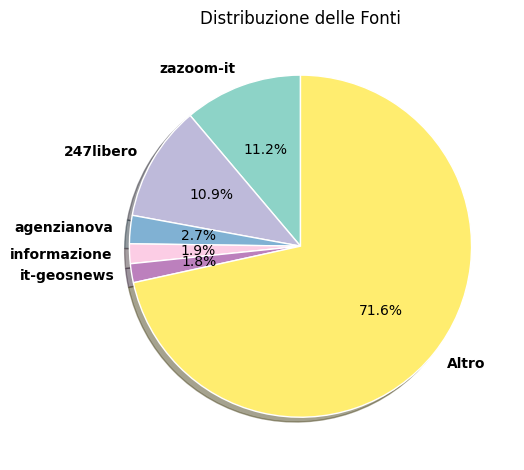

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che tu abbia un dizionario source_count_dict_p1 con i dati delle fonti e dei conteggi

# Estrai i titoli e i conteggi dal dizionario
labels = np.array(list(source_count_dict_p2.keys()))
sizes = np.array(list(source_count_dict_p2.values()), dtype=float)  # Converte i valori in float

# Trova gli indici dei 5 titoli con il maggior numero di articoli
top_five = sizes.argsort()[-5:][::-1]

# Calcola il totale dei conteggi delle fonti tranne le prime 5
other_size = np.sum(sizes) - np.sum(sizes[top_five])

# Aggiungi la categoria "Altro" alla lista di etichette e alle dimensioni
labels1 = np.append(labels[top_five], 'Altro')
sizes1 = np.append(sizes[top_five], other_size)

# Evidenzia i 5 titoli principali con colori diversi
colors = plt.cm.Set3(np.linspace(0, 1, len(labels1)))

# Crea il grafico a torta
fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes1, labels=labels1, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

# Aggiungi bordi alle fette
for wedge in wedges:
    wedge.set_edgecolor('white')

# Aggiungi label alle fette con percentuali
for text in texts:
    text.set_fontsize(10)
    text.set_fontweight('bold')

# Aggiungi titolo al grafico
ax1.set_title("Distribuzione delle Fonti")

# Mostra il grafico
plt.tight_layout()
plt.show()


## Same analysis for the second period

The files of the first time period are p2_<>.xml files. For the first time period there are 2959 files so this number will be hard coded.

In [ ]:
source_count_p2 = source_count_generator('p2', 2959)

In [ ]:
# Function to save dictionary keys into a file
def save_keys_to_txt(dictionary, filename):
    with open(filename, "w") as file:
        for key in dictionary.keys():
            file.write(key + "\n")

# Name of the file to save the keys
file_name = "p2_source.txt"

# Call the function to save the keys into the file
save_keys_to_txt(source_count_p2, file_name)

### Importing model p1-common-news

In [ ]:
import os
import gensim.models
import tempfile

#
# To load a saved model:
#
model_p1_common = gensim.models.Word2Vec.load('D:\\Data Science UNIPD\\Cluster_tesi\\tmp\\gensim-model-p1-common-newsraoyr8c6')

for index, word in enumerate(model_p1_common.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_p1_common.wv.index_to_key)} is {word}")

word #0/139170 is di
word #1/139170 is il
word #2/139170 is che
word #3/139170 is la
word #4/139170 is in
word #5/139170 is per
word #6/139170 is del
word #7/139170 is un
word #8/139170 is della
word #9/139170 is non


# Computing the embedding on the common newspapers common

The intersection of the newspapers of the two periods results in 431 journals publishing both in 2018 and 2020

In [ ]:
# Code to train all the first period
from gensim import utils
import xml.etree.ElementTree as ET
from datetime import datetime


# Leggi la lista dalle chiavi comuni dal file txt
common_titles = []
with open("p1_p2_common_newspapers_titles_list.txt", "r") as file:
    for line in file:
        common_titles.append(line.strip())


# Namespace mapping
namespace_map = {
    'emm': 'http://emm.jrc.it'
}

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, n_files=1658, period='p1'):
        self.n_files = n_files
        self.period = period

    def __iter__(self):
        for i in range(1, self.n_files + 1):
            file_path = f'D:\\Data Science UNIPD\\Cluster_tesi\\pietromaria.sanguin-data\\{self.period}_{i}.xml'
            # Parse the XML file with namespace mapping
            tree = ET.ElementTree()
            tree.parse(file_path)
            root = tree.getroot()
            channel = root.find('channel')

            for item in channel.findall('item'):
                item_source = item.find('source').text
                if item_source in common_titles:
                    item_text_elem = item.find('emm:text', namespaces=namespace_map)
                    if item_text_elem is None:
                        print('Elemento None', item_text_elem)
                        continue  # Skip this iteration if item_text is None
                    item_text = item_text_elem.text
                    if item_text is None:
                        continue  # Skip this iteration if item_text is still None after retrieval
                    processed_text = utils.simple_preprocess(item_text)
                    yield processed_text


In [ ]:
import gensim.models

#sentences = MyCorpus(n_files=1660, period='p1', political_side='1')
sentences = MyCorpus(n_files=2959, period='p2')
model = gensim.models.Word2Vec(sentences=sentences, vector_size=300, window = 5, seed=42, epochs= 5)

In [ ]:
import os
import gensim.models
import tempfile

# Specify the folder where you want to create the temporary file
tmp_dir = "D:\\Data Science UNIPD\\Cluster_tesi\\tmp"

# Ensure the temporary directory exists, create if not
os.makedirs(tmp_dir, exist_ok=True)

# Create a temporary file with a specific prefix in the specified directory
with tempfile.NamedTemporaryFile(prefix='gensim-model-p2-common-news', dir=tmp_dir, delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)

    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.

In [ ]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/148178 is di
word #1/148178 is il
word #2/148178 is che
word #3/148178 is la
word #4/148178 is in
word #5/148178 is per
word #6/148178 is del
word #7/148178 is un
word #8/148178 is della
word #9/148178 is non


## Nord Sud, another analysis

In [ ]:
#Function to import a txt file as a dictionary
def import_txt_as_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            data_dict[key.strip()] = value.strip()
    return data_dict

file_path = 'p1_p2_common_news_regions.txt'
source_classification_dict = import_txt_as_dict(file_path)

In [ ]:
#The code for the function is present before

n_files = 1659
period = 'p1'
political_side = 'sud'
text_file_name = 'p1_sud.txt'

accessing_multiple_xml_text(n_files, period, source_classification_dict, political_side, text_file_name)

In [ ]:
# Utilizzo della funzione per preelaborare il testo
output_filename = text_file_name.replace(".txt", "") + "_preprocessed.txt"
preprocessing(text_file_name, output_filename)